In [ ]:
!unzip -qq image.zip -d ./data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
Dataset = pd.read_csv('./train_label.csv')
Dataset.head()

,image_path,label
0,train_0.jpeg,DRUSEN
1,train_1.jpeg,NORMAL
2,train_2.jpeg,CNV
3,train_3.jpeg,CNV
4,train_4.jpeg,DRUSEN


In [ ]:
Dataset["label"] = Dataset["label"].astype(str)

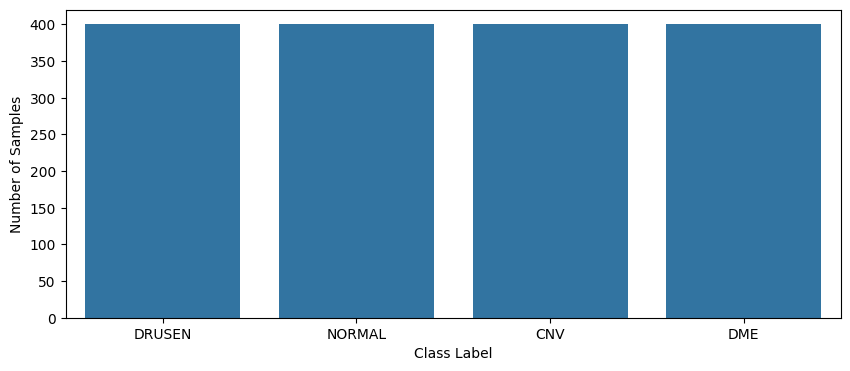

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))
sns.countplot(x ='label', data=Dataset)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
Data_train, Data_test = train_test_split(Dataset, test_size=0.2)
#datagen = ImageDataGenerator(rescale=1./255)

datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    #fill_mode='nearest'
)
"""
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True, # 추가
    brightness_range=[0.5, 1.5], # 추가
    channel_shift_range=50.0, # 추가
    fill_mode='nearest',
    validation_split=0.2 # 추가
)"""

dir1 = './data/train/'

train_gen=datagen.flow_from_dataframe(dataframe = Data_train,           # Training Dataframe
                                      directory=dir1,                   # Training set Directory
                                      batch_size=20,                    # Size of Batch
                                      class_mode="categorical",         # Type of Labels
                                      x_col="image_path",               # Input Column
                                      color_mode="rgb",                 # Image Format
                                      y_col="label",                    # Target Column
                                      target_size=(224,224))            # Image Size

valid_gen=datagen.flow_from_dataframe(dataframe = Data_test,            # Training Dataframe
                                      directory=dir1,                   # Training set Directory
                                      batch_size=20,                    # Size of Batch
                                      class_mode="categorical",         # Type of Labels
                                      x_col="image_path",               # Input Column
                                      color_mode="rgb",                 # Image Format
                                      y_col="label",                    # Target Column
                                      target_size=(224,224))

Found 1280 validated image filenames belonging to 4 classes.
Found 320 validated image filenames belonging to 4 classes.


In [ ]:
import keras
import math
from keras import Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

ResNet_model = keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224,224, 3))
for layer in ResNet_model.layers[:-15]:       # Freezing all layers other than last 15 Layers
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='swish')(x)
x = BatchNormalization()(x)  # Batch Normalization 추가
x = Dropout(0.25)(x)
x = Dense(units=512, activation='swish')(x)
x = BatchNormalization()(x)  # Batch Normalization 추가
x = Dropout(0.25)(x)
output  = Dense(units=4, activation='softmax')(x)
model = Model(ResNet_model.input, output)

#print(model.summary())

#STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
#STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
STEP_SIZE_TRAIN = math.ceil(train_gen.n / train_gen.batch_size)
STEP_SIZE_VALID = math.ceil(valid_gen.n / valid_gen.batch_size)

#print(STEP_SIZE_TRAIN)
#print(STEP_SIZE_VALID)

# 학습률 감소 스케줄러 추가
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.0001,
#    decay_steps=5 * STEP_SIZE_TRAIN ,
#    decay_rate=0.96,
#    staircase=True)

#lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#    initial_learning_rate=0.0001,  # 초기 학습률
#    decay_steps=5 * STEP_SIZE_TRAIN,  # 총 감소 스텝 수
#    alpha=0.0  # 최소 학습률 값 (initial_learning_rate * alpha)
#)
lr_schedule = 0.0001
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Nadam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [ ]:
# EarlyStopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 모니터링할 값
    patience=5,              # 개선되지 않는 epoch 수 (여기서는 3으로 설정)
    restore_best_weights=True # 최적의 가중치를 복원
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=1e-7)  # 학습률 감소 콜백 추가

# 모델 학습
transfer_learning_history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,  # 학습 epoch 수를 10으로 늘림
    callbacks=[early_stopping,reduce_lr]  # 콜백 추가
)

<ipython-input-15-1cb27699eb1b>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(


Epoch 1/50
64/64 [==============================] - 71s 758ms/step - loss: 1.3508 - accuracy: 0.5141 - val_loss: 1.0321 - val_accuracy: 0.5906 - lr: 1.0000e-04
Epoch 2/50
64/64 [==============================] - 31s 474ms/step - loss: 0.8204 - accuracy: 0.6844 - val_loss: 0.8355 - val_accuracy: 0.6594 - lr: 1.0000e-04
Epoch 3/50
64/64 [==============================] - 26s 410ms/step - loss: 0.6269 - accuracy: 0.7773 - val_loss: 0.7131 - val_accuracy: 0.7344 - lr: 1.0000e-04
Epoch 4/50
64/64 [==============================] - 26s 414ms/step - loss: 0.5310 - accuracy: 0.8156 - val_loss: 0.6886 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 5/50
64/64 [==============================] - 28s 442ms/step - loss: 0.4174 - accuracy: 0.8414 - val_loss: 0.7396 - val_accuracy: 0.7344 - lr: 1.0000e-04
Epoch 6/50
64/64 [==============================] - 27s 418ms/step - loss: 0.3734 - accuracy: 0.8656 - val_loss: 0.6977 - val_accuracy: 0.7406 - lr: 1.0000e-04
Epoch 7/50
64/64 [======================

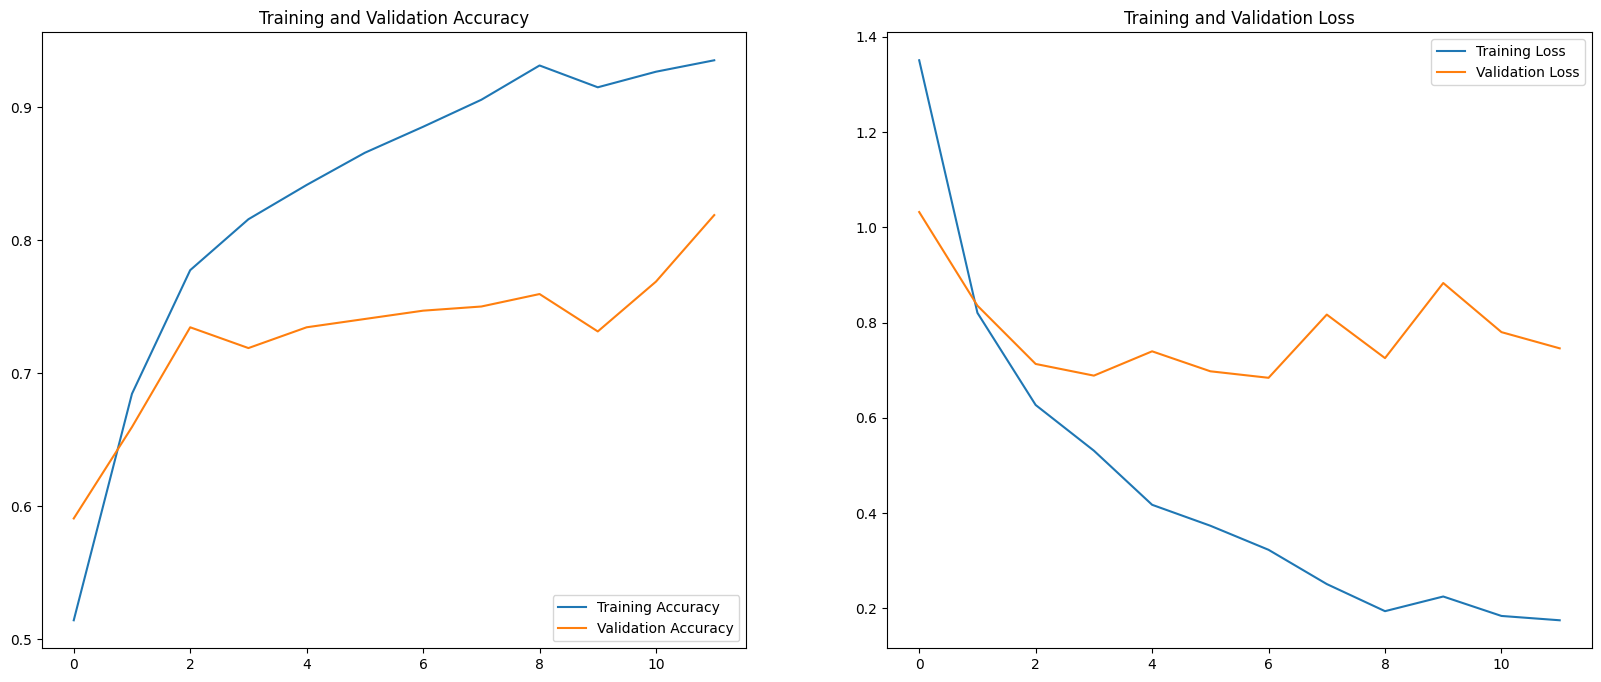

In [ ]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# test.csv 파일 읽기
test_dataset = pd.read_csv('./test.csv')
dir2 = './data/test/'
#test_dataset["label"] = test_dataset["label"].astype(str)

# ImageDataGenerator 생성
test_datagen = ImageDataGenerator(rescale=1./255)

# 테스트 데이터 생성기 만들기
test_gen = test_datagen.flow_from_dataframe(dataframe=test_dataset,
                                            directory=dir2,
                                            x_col="image_path",
                                            color_mode="rgb",
                                            y_col=None,
                                            batch_size=20,
                                            class_mode=None,
                                            target_size=(224,224),
                                            shuffle=False)

# 모델을 사용하여 예측 수행
predictions = model.predict_generator(test_gen, steps=test_gen.n // test_gen.batch_size + 1)
predicted_labels = predictions.argmax(axis=1)

# 예측 결과를 dataframe으로 변환
submission_df = pd.DataFrame({'image_path': test_dataset['image_path'], 'label': predicted_labels})

# submission.csv 파일로 저장
submission_df.to_csv('submission.csv', index=False)

print("Submission file has been created successfully!")


KeyError: None

In [ ]:
test_dataset.head()

,image_path
0,test_0.jpeg
1,test_1.jpeg
2,test_2.jpeg
3,test_3.jpeg
4,test_4.jpeg


# ResNet

In [ ]:
import keras
ResNet_model = keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(150,150, 3))

In [ ]:
from keras import Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from keras.models import Sequential

In [ ]:
for layer in ResNet_model.layers[:-15]:       # Freezing all layers other than last 15 Layers
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='swish')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='swish')(x)
x = Dropout(0.3)(x)
output  = Dense(units=6, activation='softmax')(x)
model = Model(ResNet_model.input, output)

In [ ]:
#print(model.summary())

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Nadam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [ ]:
#STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
#STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
STEP_SIZE_TRAIN = math.ceil(train_gen.n / train_gen.batch_size)
STEP_SIZE_VALID = math.ceil(valid_gen.n / valid_gen.batch_size)

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

152
38


In [ ]:
# EarlyStopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 모니터링할 값
    patience=3,              # 개선되지 않는 epoch 수 (여기서는 3으로 설정)
    restore_best_weights=True # 최적의 가중치를 복원
)

# 모델 학습
transfer_learning_history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=30,  # 학습 epoch 수를 10으로 늘림
    callbacks=[early_stopping]  # 콜백 추가
)

<ipython-input-221-ec276ea24cb9>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(


Epoch 1/30
152/152 [==============================] - 22s 145ms/step - loss: 0.2424 - accuracy: 0.9201 - val_loss: 0.3408 - val_accuracy: 0.8851
Epoch 2/30
152/152 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9729

In [ ]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# test.csv 파일 읽기
test_dataset = pd.read_csv('./data/test.csv')
#test_dataset["label"] = test_dataset["label"].astype(str)

# ImageDataGenerator 생성
test_datagen = ImageDataGenerator(rescale=1./255)

# 테스트 데이터 생성기 만들기
test_gen = test_datagen.flow_from_dataframe(dataframe=test_dataset,
                                            directory=dir1,
                                            x_col="image_name",
                                            color_mode="rgb",
                                            y_col=None,
                                            batch_size=20,
                                            class_mode="categorical",
                                            target_size=(150, 150),
                                            shuffle=False)

# 모델을 사용하여 예측 수행
predictions = model.predict_generator(test_gen, steps=test_gen.n // test_gen.batch_size + 1)
predicted_labels = predictions.argmax(axis=1)

# 예측 결과를 dataframe으로 변환
submission_df = pd.DataFrame({'image_name': test_dataset['image_name'], 'label': predicted_labels})

# submission.csv 파일로 저장
submission_df.to_csv('submission.csv', index=False)

print("Submission file has been created successfully!")


# Densenet


In [ ]:
!unzip -qq skku-2024-1-machine-learning-third-project.zip -d ./data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense,  GlobalAveragePooling2D, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Nadam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
Dataset = pd.read_csv('./data/train.csv')
Dataset["label"] = Dataset["label"].astype(str)

Data_train, Data_test = train_test_split(Dataset, test_size=0.2)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

dir1 = './data/SceneImages/'
train_gen=datagen.flow_from_dataframe(dataframe = Data_train,           # Training Dataframe
                                      directory=dir1,                   # Training set Directory
                                      batch_size=20,                    # Size of Batch
                                      class_mode="categorical",         # Type of Labels
                                      x_col="image_name",               # Input Column
                                      color_mode="rgb",                 # Image Format
                                      y_col="label",                    # Target Column
                                      target_size=(150,150))            # Image Size

valid_gen=datagen.flow_from_dataframe(dataframe = Data_test,            # Training Dataframe
                                      directory=dir1,                   # Training set Directory
                                      batch_size=20,                    # Size of Batch
                                      class_mode="categorical",         # Type of Labels
                                      x_col="image_name",               # Input Column
                                      color_mode="rgb",                 # Image Format
                                      y_col="label",                    # Target Column
                                      target_size=(150,150))

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

Found 3028 validated image filenames belonging to 6 classes.
Found 757 validated image filenames belonging to 6 classes.


In [ ]:
basemodel = tf.keras.applications.DenseNet121(weights = "imagenet",
                                              input_shape = (150,150, 3),include_top=False,pooling='max')
x= basemodel.output
x= keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output = Dense(6, activation="softmax")(x)

#x = basemodel.output
#x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
#x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
#x = Dropout(rate=0.5)(x)  # Dropout 비율을 0.45에서 0.5로 변경
#x = Dense(256, activation='relu')(x)
#output = Dense(6, activation="softmax")(x)

model = tf.keras.Model(inputs = basemodel.inputs, outputs = output)
model.compile(Nadam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
# EarlyStopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 모니터링할 값
    patience=3,              # 개선되지 않는 epoch 수 (여기서는 3으로 설정)
    restore_best_weights=True # 최적의 가중치를 복원
)
checkpoint_path = "best_model.keras"  # 최적의 모델을 저장할 파일명 및 경로
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# 모델 학습
transfer_learning_history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,  # 학습 epoch 수를 10으로 늘림
    callbacks=[early_stopping,model_checkpoint]  # 콜백 추가
)

In [ ]:
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(14)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model = load_model(checkpoint_path)

# test.csv 파일 읽기
test_dataset = pd.read_csv('./data/test.csv')

# ImageDataGenerator 생성
test_datagen = ImageDataGenerator(rescale=1./255)

# 테스트 데이터 생성기 만들기
test_gen = test_datagen.flow_from_dataframe(dataframe=test_dataset,
                                            directory=dir1,
                                            x_col="image_name",
                                            color_mode="rgb",
                                            y_col=None,
                                            batch_size=20,
                                            class_mode=None,
                                            target_size=(150, 150),
                                            shuffle=False)

# 모델을 사용하여 예측 수행
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_labels = predictions.argmax(axis=1)

# 예측 결과를 dataframe으로 변환
submission_df = pd.DataFrame({'image_name': test_dataset['image_name'], 'label': predicted_labels})

# submission.csv 파일로 저장
submission_df.to_csv('submission.csv', index=False)

Found 440 validated image filenames.
22/22 [==============================] - 3s 33ms/step


# CNN

In [ ]:
! pip install fastai

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
path = './data/SceneImages'

In [ ]:
np.random.seed(40)
data = ImageDataLoaders.from_folder(path, train='.', valid_pct=0.2,
                                    item_tfms=Resize(460),
                                    batch_tfms=[*aug_transforms(size=150), Normalize.from_stats(*imagenet_stats)],
                                    num_workers=-1)

AttributeError: AxesImage.set() got an unexpected keyword argument 'rows'

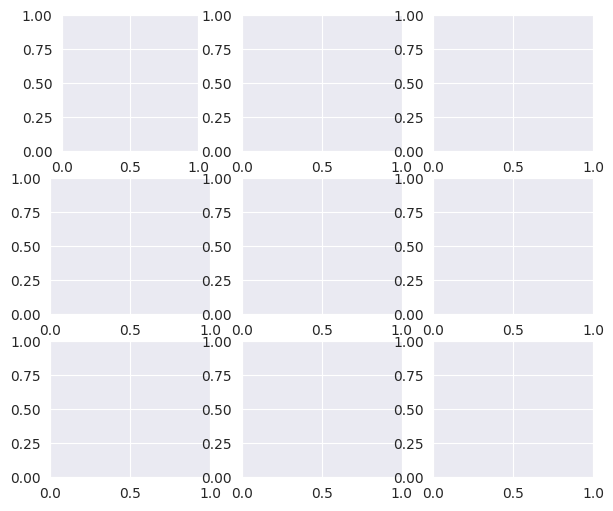

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
data.c

1